In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import copy
import os
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandAugment, TrivialAugmentWide

In [ ]:
data_dir = "/kaggle/input/data-snake/kaggle/working/data"   # Cấu trúc thư mục: data/train, data/val
num_classes = 124
batch_size = 32
num_epochs = 30
lr = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# train_transform = transforms.Compose([
#     transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomVerticalFlip(p=0.2),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
#     transforms.ToTensor(),
    
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# val_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406],
#                          [0.229, 0.224, 0.225])
# ])

# image_datasets = {
#     'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform),
#     'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transform)
# }

# dataloaders = {
#     x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
#     for x in ['train', 'val']
# }

# dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])
image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transform)
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Hàm helper để "bỏ chuẩn hóa" ảnh và hiển thị
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))  # chuyển tensor về (H, W, C)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # đảo chuẩn hóa
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Lấy 1 batch ảnh từ dataloader train
inputs, classes = next(iter(dataloaders['train']))

# Hiển thị 8 ảnh đầu tiên
plt.figure(figsize=(16, 8))
for i in range(8):
    ax = plt.subplot(2, 4, i+1)
    imshow(inputs[i])
    label_name = image_datasets['train'].classes[classes[i]]  # lấy tên class
    ax.set_title(label_name)
plt.tight_layout()
plt.show()


In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import time
import copy
import os
from torchvision.transforms import AutoAugment, AutoAugmentPolicy, RandAugment, TrivialAugmentWide

# =========================
# 0. Config
# =========================
data_dir = "/kaggle/input/data-snake/kaggle/working/data"   # Cấu trúc thư mục: data/train, data/val
num_classes = 124
batch_size = 32
num_epochs = 30
lr = 5e-5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# 1. Data Augmentation
# =========================
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), train_transform),
    'val': datasets.ImageFolder(os.path.join(data_dir, 'val'), val_transform)
}

dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# =========================
# 2. MixUp Function
# =========================
def mixup_data(x, y, alpha=1.0):
    """
    Returns mixed inputs, pairs of targets, and lambda
    """
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

# =========================
# 3. CutMix Function
# =========================
def cutmix_data(x, y, alpha=1.0):
    lam = np.random.beta(alpha, alpha)
    batch_size, _, h, w = x.size()
    index = torch.randperm(batch_size).to(x.device)

    cut_rat = np.sqrt(1. - lam)
    cut_w = int(w * cut_rat)
    cut_h = int(h * cut_rat)

    # Random center
    cx = np.random.randint(w)
    cy = np.random.randint(h)

    bbx1 = np.clip(cx - cut_w // 2, 0, w)
    bby1 = np.clip(cy - cut_h // 2, 0, h)
    bbx2 = np.clip(cx + cut_w // 2, 0, w)
    bby2 = np.clip(cy + cut_h // 2, 0, h)

    x[:, :, bby1:bby2, bbx1:bbx2] = x[index, :, bby1:bby2, bbx1:bbx2]
    y_a, y_b = y, y[index]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (w * h))
    return x, y_a, y_b, lam

# =========================
# 4. Mixed Loss Function
# =========================
def mixup_criterion(criterion, pred, y_a, y_b, lam):
    """
    Calculate mixup/cutmix loss
    """
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# =========================
# 5. Model
# =========================
model = models.swin_s(weights="IMAGENET1K_V1")  # pretrained Swin-Small
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# =========================
# 6. Loss, Optimizer, Scheduler
# =========================
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

# ================================
# 7. Checkpoint helpers
# ================================
def save_checkpoint(model, optimizer, scheduler, epoch, history, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'history': history
    }
    torch.save(checkpoint, path)
    print(f"✅ Saved checkpoint at {path}")

def load_checkpoint(model, optimizer, scheduler, path, device):
    checkpoint = torch.load(path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    history = checkpoint['history']
    print(f"✅ Loaded checkpoint from {path} (epoch {epoch})")
    return model, optimizer, scheduler, epoch, history

# =========================
# 8. Training Loop with Mixed Augmentation
# =========================
def train_model(model, criterion, optimizer, scheduler, num_epochs=30, 
                use_mixed_aug=True, mixup_alpha=0.4, cutmix_alpha=1.0, mixup_prob=0.5):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    history = {
        "train_loss": [],
        "val_loss": [],
        "train_acc": [],
        "val_acc": []
    }
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 50)
        
        # Track augmentation usage
        mixup_count = 0
        cutmix_count = 0
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0
            
            for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    if phase == 'train' and use_mixed_aug:
                        # 🎯 Randomly choose between MixUp and CutMix
                        if np.random.random() < mixup_prob:
                            # Use MixUp
                            inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, mixup_alpha)
                            augmentation_type = "MixUp"
                            mixup_count += 1
                        else:
                            # Use CutMix
                            inputs, targets_a, targets_b, lam = cutmix_data(inputs, labels, cutmix_alpha)
                            augmentation_type = "CutMix"
                            cutmix_count += 1
                        
                        outputs = model(inputs)
                        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
                        
                        # For accuracy calculation during training (approximate)
                        _, preds = torch.max(outputs, 1)
                        running_corrects += (lam * preds.eq(targets_a.data).sum().float() + 
                                           (1 - lam) * preds.eq(targets_b.data).sum().float())
                        
                        # Print augmentation info for first few batches of first epoch
                        if batch_idx < 3 and epoch == 0:
                            print(f"  📊 Batch {batch_idx}: {augmentation_type} (λ={lam:.3f})")
                    
                    else:
                        # Validation or no augmentation
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)
                        running_corrects += torch.sum(preds == labels.data)
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
            
            if phase == 'train':
                scheduler.step()
                total_batches = len(dataloaders[phase])
                print(f"  🔄 MixUp: {mixup_count}/{total_batches} batches | CutMix: {cutmix_count}/{total_batches} batches")
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double().item() / dataset_sizes[phase]
            
            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Save history
            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)
            
            # Save best model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(model, optimizer, scheduler, epoch+1, history, "/kaggle/working/best_checkpoint_mixed.pth")
        
        # Save checkpoint every 5 epochs
        if (epoch + 1) % 5 == 0:
            save_checkpoint(model, optimizer, scheduler, epoch+1, history, f"/kaggle/working/checkpoint_mixed_epoch{epoch+1}.pth")
        
        print()
    
    print(f'🏆 Best val Acc: {best_acc:.4f}')
    model.load_state_dict(best_model_wts)
    return model, history

# =========================
# 9. Run Training with Mixed Augmentation
# =========================
model, history = train_model(
    model,
    criterion,
    optimizer,
    scheduler,
    num_epochs=num_epochs,
    use_mixed_aug=True,      # Enable Mixed Augmentation
    mixup_alpha=0.4,         # MixUp alpha (less aggressive)
    cutmix_alpha=1.0,        # CutMix alpha (standard)
    mixup_prob=0.5           # 50% MixUp, 50% CutMix
)

# Save final best model
torch.save(model.state_dict(), "/kaggle/working/swin_tiny_best_mixed.pth")
print("✅ Training complete with Mixed Augmentation and best model saved.")

Downloading: "https://download.pytorch.org/models/swin_s-5e29d889.pth" to /root/.cache/torch/hub/checkpoints/swin_s-5e29d889.pth
100%|██████████| 190M/190M [00:01<00:00, 175MB/s]  


Epoch 1/30
--------------------------------------------------
  📊 Batch 0: CutMix (λ=0.697)
  📊 Batch 1: MixUp (λ=0.064)
  📊 Batch 2: MixUp (λ=0.872)
  🔄 MixUp: 360/676 batches | CutMix: 316/676 batches
train Loss: 3.1997 Acc: 0.3672
val Loss: 1.6650 Acc: 0.7319
✅ Saved checkpoint at /kaggle/working/best_checkpoint_mixed.pth

Epoch 2/30
--------------------------------------------------
  🔄 MixUp: 357/676 batches | CutMix: 319/676 batches
train Loss: 2.3477 Acc: 0.5795
val Loss: 1.3712 Acc: 0.8265
✅ Saved checkpoint at /kaggle/working/best_checkpoint_mixed.pth

Epoch 3/30
--------------------------------------------------
  🔄 MixUp: 348/676 batches | CutMix: 328/676 batches
train Loss: 2.1123 Acc: 0.6369
val Loss: 1.2652 Acc: 0.8565
✅ Saved checkpoint at /kaggle/working/best_checkpoint_mixed.pth

Epoch 4/30
--------------------------------------------------
  🔄 MixUp: 350/676 batches | CutMix: 326/676 batches
train Loss: 1.9945 Acc: 0.6619
val Loss: 1.2035 Acc: 0.8771
✅ Saved checkpoin

In [3]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


# =========================
# 7. Evaluation on Test Set
# =========================
# Load lại test dataset
test_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), val_transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

# Lấy mapping index -> class name
class_names = test_dataset.classes
num_classes = len(class_names)

# Load best model đã save
model = models.swin_s(weights=None)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# --- Load checkpoint ---
checkpoint_path = "/kaggle/working/best_checkpoint_mixed.pth"  # thay bằng checkpoint bạn muốn
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Cách thuần tuý
all_labels = []
all_preds = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

# =========================
# 8. Tính accuracy
# =========================
overall_acc = accuracy_score(all_labels, all_preds)
print(f"\nTest Accuracy: {overall_acc:.4f}")

# =========================
# 9. Accuracy từng class
# =========================
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

print("\nAccuracy theo từng class:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
    correct = np.sum(all_preds[idx] == all_labels[idx])
    total = np.sum(idx)
    print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")

# =========================
# 10. Classification Report (optional)
# =========================
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Test Accuracy: 0.9406

Accuracy theo từng class:
Achalinus_rufescens        Acc: 1.0000  (13/13)
Achalinus_spinalis         Acc: 0.9286  (13/14)
Acrochordus_granulatus     Acc: 0.9535  (41/43)
Acrochordus_javanicus      Acc: 1.0000  (8/8)
Ahaetulla_fusca            Acc: 1.0000  (27/27)
Ahaetulla_prasina          Acc: 0.9500  (19/20)
Ahaetulla_rufusoculara     Acc: 1.0000  (9/9)
Amphiesma_stolatum         Acc: 0.9737  (74/76)
Blue-lipped_sea_krait      Acc: 0.9756  (80/82)
Boiga_cyanea               Acc: 0.9494  (75/79)
Boiga_guangxiensis         Acc: 0.8750  (7/8)
Boiga_jaspidea             Acc: 1.0000  (41/41)
Boiga_kraepelini           Acc: 0.9701  (65/67)
Boiga_multomaculata        Acc: 0.9900  (99/100)
Boiga_siamensis            Acc: 0.9355  (29/31)
Bungarus_candidus          Acc: 0.9437  (67/71)
Bungarus_fasciatus         Acc: 1.0000  (86/86)
Calamaria_septentrionalis  Acc: 0.7727  (17/22)
Calliophis_maculiceps      Acc: 1.0000  (18/18)
Calloselasma_rhodostoma    Acc: 0.9706  (99

🏆 Best Validation Accuracy: 0.9421 (Epoch 27)


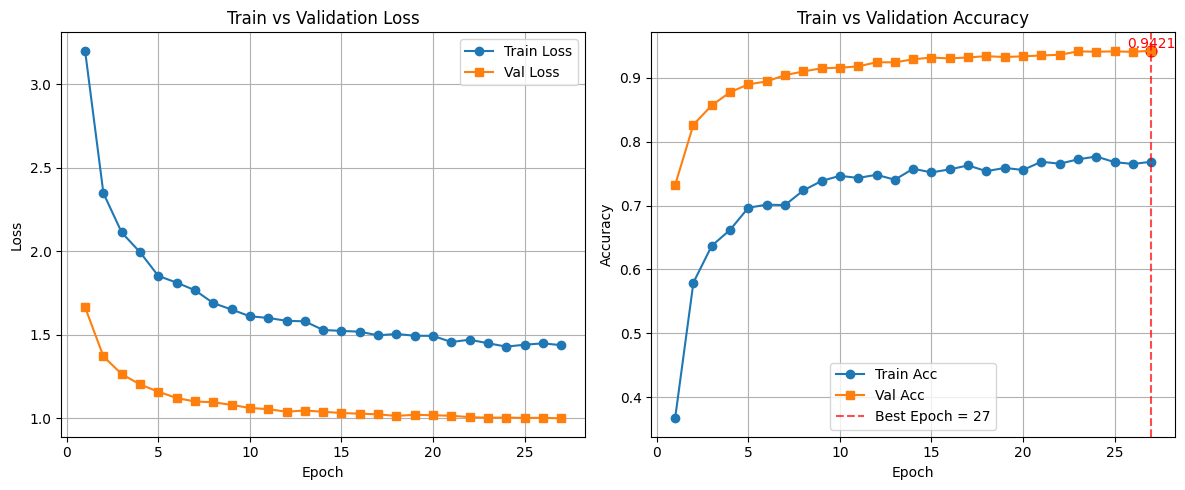

In [4]:
import torch
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =========================
# 1. Load checkpoint
# =========================
checkpoint_path = "/kaggle/working/best_checkpoint_mixed.pth"
checkpoint = torch.load(checkpoint_path, map_location=device)
history = checkpoint['history']

# =========================
# 2. Tạo biến epoch & tìm best acc
# =========================
train_acc = history["train_acc"]
val_acc = history["val_acc"]
train_loss = history["train_loss"]
val_loss = history["val_loss"]

epochs = range(1, len(train_acc) + 1)
best_val_acc = max(val_acc)
best_epoch = np.argmax(val_acc) + 1

print(f"🏆 Best Validation Accuracy: {best_val_acc:.4f} (Epoch {best_epoch})")

# =========================
# 3. Vẽ Loss và Accuracy
# =========================
plt.figure(figsize=(12,5))

# --- Loss ---
plt.subplot(1,2,1)
plt.plot(epochs, train_loss, 'o-', label="Train Loss")
plt.plot(epochs, val_loss, 's-', label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.grid(True)

# --- Accuracy ---
plt.subplot(1,2,2)
plt.plot(epochs, train_acc, 'o-', label="Train Acc")
plt.plot(epochs, val_acc, 's-', label="Val Acc")
plt.axvline(best_epoch, color='r', linestyle='--', alpha=0.7, label=f"Best Epoch = {best_epoch}")
plt.scatter(best_epoch, best_val_acc, color='red', s=60)
plt.text(best_epoch, best_val_acc + 0.005, f"{best_val_acc:.4f}", color='red', ha='center')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [5]:
print("\n⚠️ Các class dưới 70% accuracy:")
for i, class_name in enumerate(class_names):
    idx = (all_labels == i)
    if np.sum(idx) == 0:
        acc = 0.0
        correct, total = 0, 0
    else:
        acc = np.mean(all_preds[idx] == all_labels[idx])
        correct = np.sum(all_preds[idx] == all_labels[idx])
        total = np.sum(idx)

    if acc < 0.7:  # dưới 70%
        print(f"{class_name:25s}  Acc: {acc:.4f}  ({correct}/{total})")



⚠️ Các class dưới 70% accuracy:
Lycodon_chapaensis         Acc: 0.5000  (5/10)
Lycodon_truongi            Acc: 0.6250  (5/8)
Pareas_berdmorei           Acc: 0.6786  (19/28)
Pareas_hamptoni            Acc: 0.1429  (1/7)
Ptyas_mucosa               Acc: 0.6000  (9/15)
Sinomicrurus_peinani       Acc: 0.6250  (5/8)


In [7]:
import torch
from torchvision import transforms, datasets, models
from PIL import Image
import requests
from io import BytesIO
import os

# =====================
# 1. Cấu hình
# =====================
num_classes = 124
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# =====================
# 2. Load model
# =====================
model = models.swin_s(weights=None)
model.head = nn.Linear(model.head.in_features, num_classes)
model = model.to(device)

# --- Load checkpoint ---
checkpoint_path = "/kaggle/working/best_checkpoint_mixed.pth"  # thay bằng checkpoint bạn muốn
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# =====================
# 3. Transform
# =====================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

# =====================
# 4. Lấy class_names từ folder train
# =====================
data_dir = "/kaggle/input/data-snake/kaggle/working/data"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'))
class_names = train_dataset.classes

# =====================
# 5. Hàm dự đoán
# =====================
def predict_from_url(url, class_names):
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)

    with torch.no_grad():
        outputs = model(img_tensor)
        probs = torch.softmax(outputs, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()

    print(f"Predicted class: {class_names[pred_idx]} (prob = {probs[0][pred_idx]:.4f})")
    return class_names[pred_idx]

# =====================
# 6. Ví dụ sử dụng
# =====================
url = "https://vietnamsnakes.com/storage/snakes/species/46/1748341202_0.jpg"
predict_from_url(url, class_names)


Predicted class: Bungarus_fasciatus (prob = 0.6985)


'Bungarus_fasciatus'